# Step 2: Feature Engineering

模型的目标是根据用户的第一次购买信息来预测是否会再次购买。

在上一步中，我们发现各商品是有类别的，因此不同的用户关注的商品类别是不同的，因此首先我们把商品根据关键词分门别类。另外一个原因是，假如不分类，一共3000多种商品，根据用户的购买行为来预测下一种商品显然是无法做到精确预测的，然而分组后，我们只需要预测下一次购买在5类商品的哪一类就行，可靠性更强。

## 2.1 商品特征
### 2.1.1 商品分类

In [1]:
# 导入相关modules
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from lib.plot_results import plot_wordcloud
import datetime
import os

In [2]:
# 导入数据
df = pd.read_csv('./temp/cleaned_data.csv')
keywords = np.load('./temp/keywords.npy')[:193]

这里一共有295个关键词

如何分类？

用独热编码并用稀疏矩阵记录下来。

$$
 X = \left(\begin{matrix}
   x_{11} & x_{12} & x_{13} & \dots & x_{1M}\\
   x_{21} & x_{22} & x_{23} & \dots & x_{2M} \\
   \vdots & \vdots & \vdots & \vdots & \vdots \\
   x_{N1} & x_{N2} & x_{N3} & \dots & x_{NM}
  \end{matrix}\right) 
$$

其中$x_{nm}$表示第n商品中含有第m个关键词

In [3]:
# 创建稀疏矩阵
df["Description"] = df["Description"].apply(lambda l: l.lower())
description_diff = df["Description"].unique()
X = pd.DataFrame()
for key in keywords:
    X.loc[:, key] = list(map(lambda x: int(key in x), description_diff))

In [4]:
display(X.head(4))
display(description_diff[:4])

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,plant,diner,house,square,lace,wallet,point,flag,circus,bin
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


array(['white hanging heart t-light holder', 'white metal lantern',
       'cream cupid hearts coat hanger',
       'knitted union flag hot water bottle'], dtype=object)

与此同时，由于价格也带着商品类别的信息，比如同类别的商品具有相近的价格。因此我们在特征矩阵$X$上再增加价格区间特征。

In [5]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
list_products = df['Description'].unique()
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_products):
    prix = df[df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [6]:
print("{:<8} {:<20} \n".format('区间', '商品数量') + 20 * '-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

区间       商品数量                 
--------------------
0<.<1       963                 
1<.<2       1006                
2<.<3       673                 
3<.<5       606                 
5<.<10      468                 
.>10        149                 


接下来对不同商品之间特征距离的刻画并以此来聚类，这里我们采取k-means方法，距离用sklearn默认的欧氏距离。

In [7]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10075924863157419
For n_clusters = 4 The average silhouette_score is : 0.12633012617972553
For n_clusters = 5 The average silhouette_score is : 0.12515771849985585
For n_clusters = 6 The average silhouette_score is : 0.1452859169856635
For n_clusters = 7 The average silhouette_score is : 0.1499732999284821
For n_clusters = 8 The average silhouette_score is : 0.1511490095833131
For n_clusters = 9 The average silhouette_score is : 0.14003040768187985


可以看到当用K-Means算法分成5组时，在silhouette_score的意义下最好。因此我们选择分成5组，接下来看一下每组中含有词的情况

In [8]:
n_clusters = 5
silhouette_avg = 0
while silhouette_avg < 0.14:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(silhouette_avg)
print(silhouette_avg)

0.14667879285581978
0.14667879285581978


In [9]:
pd.Series(clusters).value_counts()

1    1006
0     963
2     822
4     606
3     468
dtype: int64

In [10]:
list_des = pd.DataFrame(description_diff)

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = list_des.loc[clusters == i]
    for word in keywords:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word))

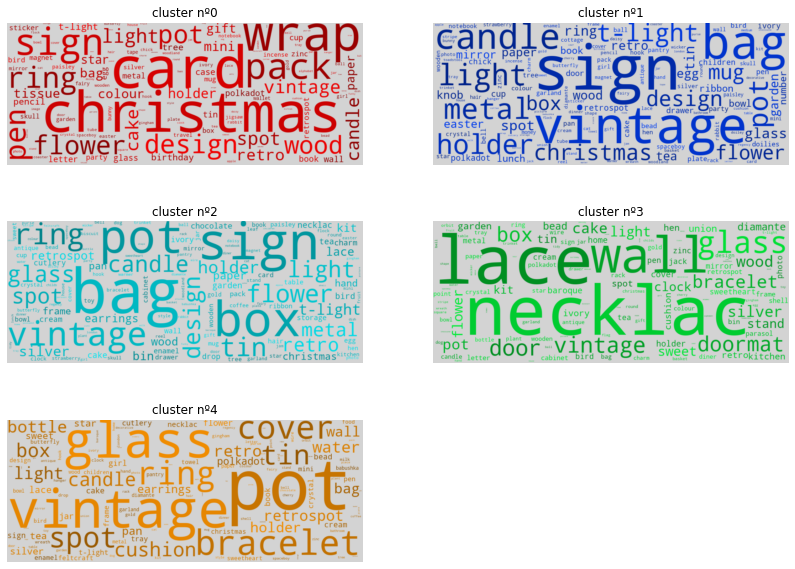

In [11]:
plot_wordcloud(occurence, n_clusters)

Note: 通过K-means算法聚类后，这里我们可以看到一些合理性，例如一组跟礼物有关(keywords: Christmas, card, wood, gift...), 有一组跟首饰有关(keywords: necklace, lace, bracelet, silver, ...)。但是还是很多词同时出现在多个组中(keywords: vintage, glass, pot, bag)，这是一个后期可以优化的地方。

> 可以再可视化以下商品分类的结果！

### 2.1.2 订单特征

由于我们考虑的目标是只根据用户第一次购买的信息去预测接下来的购买行为。因此先把数据进行按人按订单的整理。

In [12]:
list_des = list_des.rename(columns={0:"Description"})
list_des["Cluster"] = clusters


In [13]:
desc_cluster = {}
for k, v in zip(description_diff, clusters):
    desc_cluster[k] = v
df["Cluster"] = df["Description"].map(desc_cluster)

In [14]:
df[["InvoiceNo", "StockCode", "Description", "Cluster"]]

,InvoiceNo,StockCode,Description,Cluster
0,536365,85123A,white hanging heart t-light holder,2
1,536365,71053,white metal lantern,4
2,536365,84406B,cream cupid hearts coat hanger,4
3,536365,84029G,knitted union flag hot water bottle,4
4,536365,84029E,red woolly hottie white heart.,4
...,...,...,...,...
392474,581587,22613,pack of 20 spaceboy napkins,0
392475,581587,22899,children's apron dolly girl,2
392476,581587,23254,childrens cutlery dolly girl,4
392477,581587,23255,childrens cutlery circus parade,4


In [15]:
# 对每行进行销售额统计
for i in range(n_clusters):
    col_name = "Cluster_{}".format(i)
    df_temp = df[df["Cluster"] == i]
    price_temp = df_temp["Quantity"] * df_temp["UnitPrice"]
    df[col_name] = price_temp
    df[col_name].fillna(0, inplace=True)
    
df["Total_price"] = df["Quantity"] * df["UnitPrice"]
df[["InvoiceNo", "Description", "Cluster", "Total_price", "Cluster_0", "Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"]].head(10)

,InvoiceNo,Description,Cluster,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4
0,536365,white hanging heart t-light holder,2,15.30,0.0,0.00,15.3,0.0,0.00
1,536365,white metal lantern,4,20.34,0.0,0.00,0.0,0.0,20.34
2,536365,cream cupid hearts coat hanger,4,22.00,0.0,0.00,0.0,0.0,22.00
3,536365,knitted union flag hot water bottle,4,20.34,0.0,0.00,0.0,0.0,20.34
4,536365,red woolly hottie white heart.,4,20.34,0.0,0.00,0.0,0.0,20.34
5,536365,set 7 babushka nesting boxes,3,15.30,0.0,0.00,0.0,15.3,0.00
6,536365,glass star frosted t-light holder,4,25.50,0.0,0.00,0.0,0.0,25.50
7,536366,hand warmer union jack,2,11.10,0.0,0.00,11.1,0.0,0.00
8,536366,hand warmer red polka dot,1,11.10,0.0,11.10,0.0,0.0,0.00
9,536367,assorted colour bird ornament,1,54.08,0.0,54.08,0.0,0.0,0.00


In [16]:
# 对每个订单进行销售额统计
df_cluster = df.groupby(["CustomerID", "InvoiceNo"], as_index=False).Total_price.sum()
for i in range(n_clusters):
    col = "Cluster_{}".format(i)
    df_cluster.loc[:, col] = df.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[col].sum()

In [17]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [18]:
# 添加日期信息
df['InvoiceDate_int'] = df['InvoiceDate'].astype('int64')
df_temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df.drop('InvoiceDate_int', axis = 1, inplace = True)
df_cluster.loc[:, 'InvoiceDate'] = pd.to_datetime(df_temp['InvoiceDate_int'])

In [19]:
df.groupby(by=["CustomerID", "InvoiceNo"], as_index=False)[col].sum()

,CustomerID,InvoiceNo,Cluster_4
0,12347,537626,293.35
1,12347,542237,169.20
2,12347,549222,115.00
3,12347,556201,168.76
4,12347,562032,158.16
...,...,...,...
18015,18283,579673,9.75
18016,18283,580872,0.00
18017,18287,554065,15.00
18018,18287,570715,32.00


In [20]:
df_cluster.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,InvoiceDate
0,12347,537626,711.79,23.40,187.2,83.40,124.44,293.35,2010-12-07 14:57:00.000001024
1,12347,542237,475.39,84.34,130.5,91.35,0.00,169.20,2011-01-26 14:29:59.999999744
2,12347,549222,386.65,81.00,81.3,109.35,0.00,115.00,2011-04-07 10:42:59.999999488
3,12347,556201,382.52,41.40,74.4,78.06,19.90,168.76,2011-06-09 13:01:00.000000256
4,12347,562032,584.91,61.30,109.7,157.95,97.80,158.16,2011-08-02 08:48:00.000000000


### 2.1.3 按时间分集
注意到这些订单的跨度为12个月，我们可以选择把前10个月的订单作为训练集，把后2个月的订单作为测试集

In [21]:
print(df_cluster['InvoiceDate'].min(), '->',  df_cluster['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [22]:
set_training = df_cluster[df_cluster['InvoiceDate'] < pd.to_datetime(datetime.date(2011,10,1))]
set_testing = df_cluster[df_cluster['InvoiceDate'] >= pd.to_datetime(datetime.date(2011,10,1))]
df_cluster = set_training.copy(deep = True)

## 2.2 用户特征

In [23]:
print("用户数量:", df.CustomerID.nunique())

用户数量: 4297


由于用户数量达4300位，因此把用户行为相近的用户分类再进行接下来的预测是一个可取的选择。

### 2.2.1 用户特征整理

In [24]:
df_customer = df_cluster.groupby(by=["CustomerID"], as_index=False).InvoiceNo.count().rename(columns={"InvoiceNo":"count"})
df_customer.loc[:, ["Total_price", "Cluster_0", "Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"]] = df_cluster.groupby(by=["CustomerID"], as_index=False)["Total_price", "Cluster_0", "Cluster_1", "Cluster_2", "Cluster_3", "Cluster_4"].sum()

c:\users\edwin\anaconda3\envs\e-commerce data\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [25]:
last_date = df_cluster['InvoiceDate'].max().date()

first_registration = pd.DataFrame(df_cluster.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(df_cluster.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

df_customer.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
df_customer.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

df_customer[:5]

,CustomerID,count,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,LastPurchase,FirstPurchase
0,12347,5,2541.26,291.44,583.10,520.11,242.14,904.47,59,297
1,12348,4,1186.68,432.68,754.00,0.00,0.00,0.00,5,288
2,12350,1,294.40,39.10,162.00,93.30,0.00,0.00,240,240
3,12352,6,1154.01,10.20,337.46,169.05,296.60,340.70,2,226
4,12353,1,89.00,0.00,11.60,57.50,19.90,0.00,134,134


改变一些特征，把各用户在各类中的花费改为各类的占比

In [26]:
for i in range(n_clusters):
    col = 'Cluster_{}'.format(i)
    df_customer.loc[:, col] = df_customer.loc[:, col] / df_customer.loc[:, 'Total_price'] * 100


In [27]:
df_customer

,CustomerID,count,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,LastPurchase,FirstPurchase
0,12347,5,2541.26,11.468327,22.945311,20.466619,9.528344,35.591400,59,297
1,12348,4,1186.68,36.461388,63.538612,0.000000,0.000000,0.000000,5,288
2,12350,1,294.40,13.281250,55.027174,31.691576,0.000000,0.000000,240,240
3,12352,6,1154.01,0.883874,29.242381,14.648920,25.701684,29.523141,2,226
4,12353,1,89.00,0.000000,13.033708,64.606742,22.359551,0.000000,134,134
...,...,...,...,...,...,...,...,...,...,...
3579,18280,1,180.60,0.000000,0.000000,41.140642,34.025471,24.833887,207,207
3580,18281,1,80.82,18.708241,20.415739,60.876021,0.000000,0.000000,110,110
3581,18282,1,100.21,20.516914,22.901906,43.109470,0.000000,13.471709,56,56
3582,18283,10,1114.72,17.276087,36.996735,35.455540,2.188890,8.082747,25,267


再添加一些用户特征, 如每个用户的最小消费额，最大消费额，平均消费额

In [28]:
df_customer.loc[:, ["min", "max", "mean"]] = df_cluster.groupby(by=["CustomerID"], as_index=False).Total_price.agg(["min","max","mean"]).reset_index(drop=False)
df_customer.head(5)

,CustomerID,count,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,LastPurchase,FirstPurchase,min,max,mean
0,12347,5,2541.26,11.468327,22.945311,20.466619,9.528344,35.591400,59,297,382.52,711.79,508.252
1,12348,4,1186.68,36.461388,63.538612,0.000000,0.000000,0.000000,5,288,20.40,569.28,296.670
2,12350,1,294.40,13.281250,55.027174,31.691576,0.000000,0.000000,240,240,294.40,294.40,294.400
3,12352,6,1154.01,0.883874,29.242381,14.648920,25.701684,29.523141,2,226,104.35,296.50,192.335
4,12353,1,89.00,0.000000,13.033708,64.606742,22.359551,0.000000,134,134,89.00,89.00,89.000


In [29]:
n1 = df_customer[df_customer['count'] == 1].shape[0]
n2 = df_customer.shape[0]
print("只够买过一次的用户占总用户的比例: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

只够买过一次的用户占总用户的比例: 1450/3584  (40.46%)


可以看出只够买一次的用户非常多，占比40%，运营过程中一个目标就是如何留住这些客户。

### 2.2.2 对用户进行分类
选取有意义的特征，对特征进行标准化，再通过PCA降维，再通过k-Means算法对用户进行无监督学习

In [30]:
customer_col = ['count','min','max','mean','Cluster_0','Cluster_1','Cluster_2','Cluster_3','Cluster_4']

In [31]:
matrix = df_customer[customer_col].copy(deep=True).values

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)

In [33]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.5703125  250.7498856  492.62570033 353.46202169  13.17530794
  25.21194595  28.31958581  16.39086395  16.90229635]


In [34]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

No handles with labels found to put in legend.


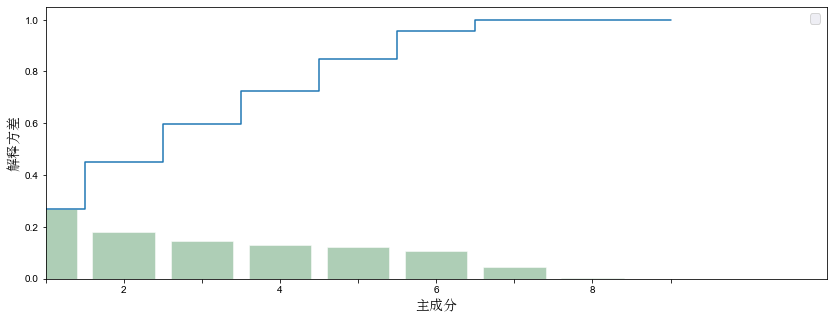

In [35]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('解释方差', fontsize = 14, fontproperties=font_set)
plt.xlabel('主成分', fontsize = 14, fontproperties=font_set)
plt.legend(loc='best', fontsize = 13);

path = "./fig/customer_PCA_explained_variance"
if not os.path.exists(path):
    plt.savefig(path, dpi=500, bbox_inches='tight')

In [36]:
pca.explained_variance_ratio_.cumsum()

array([0.26960932, 0.44892815, 0.59544687, 0.72584562, 0.84697823,
       0.95490353, 0.99754484, 1.        , 1.        ])

由此我们可以看到当主成分为6个时，累计解释方差已经大于0.97，因此我选取前6大主成分代替10个原特征进行接下来的k-means分组。

In [37]:
pca_selected = pca_samples[:, :6]
np.shape(pca_selected)

(3584, 6)

In [38]:
for i in range(5,14):
    n_clusters = i
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.167
silhouette score: 0.180
silhouette score: 0.189
silhouette score: 0.203
silhouette score: 0.200
silhouette score: 0.201
silhouette score: 0.207
silhouette score: 0.187
silhouette score: 0.190


这里经过调试发现，在组数为15时，各组人数相对分散。

In [39]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=200)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.207


In [40]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ["客户人数"]).T

,3,2,5,6,0,9,1,10,4,7,8
客户人数,1382,515,384,322,293,241,223,200,11,7,6


In [41]:
group_num = list(pd.Series(clusters_clients).value_counts()[pd.Series(clusters_clients).value_counts()>50].index)

In [42]:
mat = pd.DataFrame(pca_selected)
mat['cluster'] = pd.Series(clusters_clients)
mat50 = mat[mat['cluster'].apply(lambda l: l in group_num)]
mat50

,0,1,2,3,4,5,cluster
0,0.750484,-0.021408,-0.771293,0.252590,1.092490,0.151492,3
1,-0.862999,3.214135,-0.119541,0.919610,-0.630142,-0.149523,2
2,-0.426468,1.708346,0.960419,-0.385288,-0.175129,-1.159767,2
3,-0.564479,-0.629470,-1.060374,0.693485,0.297341,-0.766578,3
4,-0.925412,-1.524842,1.828262,-0.897158,-0.572501,-0.443459,5
...,...,...,...,...,...,...,...
3579,-0.458371,-2.185300,-0.220014,-0.698185,-0.029935,0.114508,3
3580,-1.167411,0.033388,2.158414,-0.841113,0.075070,0.382657,5
3581,-1.113824,0.305835,0.992431,-0.586274,0.556778,0.455896,3
3582,-1.086127,0.655695,1.138987,1.035007,0.207173,-0.126209,2


C:\Users\Edwin\PycharmProjects\E_Commerce_Sales_Forecast_Project\lib\plot_results.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


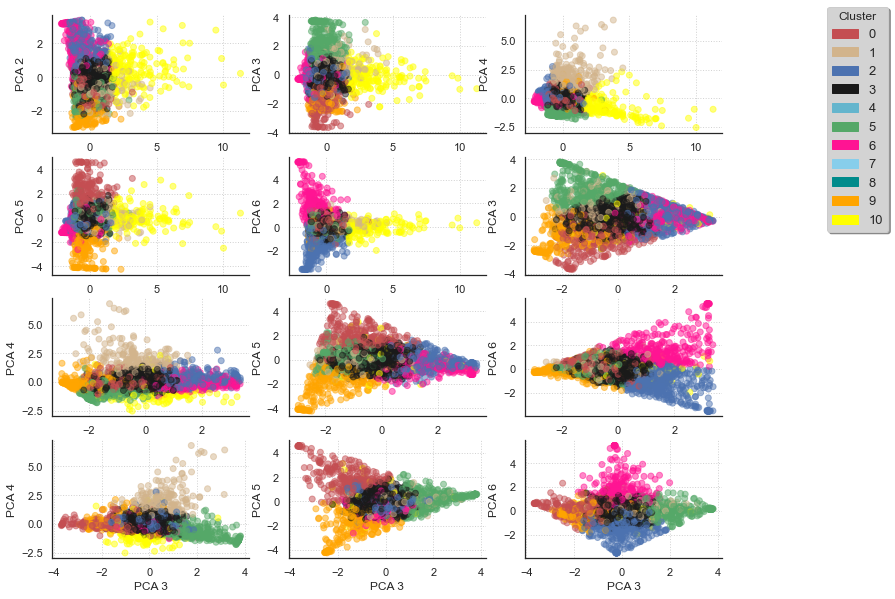

In [43]:
from lib.plot_results import plot_PCA_relation
plot_PCA_relation(mat50, n_clusters)

In [44]:
list_cols = ['count','min','max','mean','Cluster_0','Cluster_1','Cluster_2','Cluster_3','Cluster_4']
selected_customers = df_customer.copy(deep = True)
matrix = selected_customers[list_cols].values
selected_customers.loc[:, 'cluster'] = clusters_clients

In [45]:
selected_customers

,CustomerID,count,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,LastPurchase,FirstPurchase,min,max,mean,cluster
0,12347,5,2541.26,11.468327,22.945311,20.466619,9.528344,35.591400,59,297,382.52,711.79,508.252,3
1,12348,4,1186.68,36.461388,63.538612,0.000000,0.000000,0.000000,5,288,20.40,569.28,296.670,2
2,12350,1,294.40,13.281250,55.027174,31.691576,0.000000,0.000000,240,240,294.40,294.40,294.400,2
3,12352,6,1154.01,0.883874,29.242381,14.648920,25.701684,29.523141,2,226,104.35,296.50,192.335,3
4,12353,1,89.00,0.000000,13.033708,64.606742,22.359551,0.000000,134,134,89.00,89.00,89.000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,18280,1,180.60,0.000000,0.000000,41.140642,34.025471,24.833887,207,207,180.60,180.60,180.600,3
3580,18281,1,80.82,18.708241,20.415739,60.876021,0.000000,0.000000,110,110,80.82,80.82,80.820,5
3581,18282,1,100.21,20.516914,22.901906,43.109470,0.000000,13.471709,56,56,100.21,100.21,100.210,3
3582,18283,10,1114.72,17.276087,36.996735,35.455540,2.188890,8.082747,25,267,2.50,203.81,111.472,2


In [46]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('Total_price')

number of customers: 3584


In [47]:
liste_index = []
for i in range(5):
    column = 'Cluster_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'Total_price', 'Cluster_0','Cluster_1','Cluster_2','Cluster_3','Cluster_4', 'size']])

,cluster,count,min,max,mean,Total_price,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,size
0,6.0,2.180124,190.606957,279.139720,232.387009,512.078634,46.491871,23.203051,15.974581,6.494066,7.836431,322
1,2.0,2.425243,206.977942,320.624252,260.821997,649.556447,12.149169,54.761137,17.552161,6.508597,9.028937,515
2,5.0,2.338542,195.251380,320.397422,256.607742,636.643438,5.130915,11.236062,67.090835,9.485262,7.056926,384
3,9.0,2.568465,193.903237,316.116224,248.285845,677.959129,3.869407,9.777839,14.354726,61.729255,10.268773,241
4,0.0,2.191126,193.020580,301.828055,243.969114,574.602867,6.072100,13.545739,16.573454,11.598799,52.209909,293
5,3.0,3.000724,223.755716,423.981686,317.559795,940.499949,11.880515,23.970716,28.570549,17.505575,18.072645,1382
6,10.0,1.905000,968.052300,1354.976900,1133.338980,2175.831200,11.274982,25.413493,30.007957,14.739390,18.564178,200
7,8.0,1.166667,4804.130000,4816.221667,4810.175833,5403.546667,10.440085,23.965420,22.215639,23.563097,19.815760,6
8,1.0,14.739910,90.256099,1120.227444,460.351424,6240.978430,10.737548,23.804310,31.609490,16.811110,17.037542,223
9,7.0,92.000000,9.972857,1625.832857,362.168268,33514.677143,12.031316,25.015909,29.914522,18.981497,14.056757,7


In [48]:
# 保存数据
save_col = ['mean', 'Cluster_0', 'Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'cluster']
if not os.path.exists('./temp/train_set.csv'):
    selected_customers.loc[:, save_col].to_csv('./temp/train_set.csv')